In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
START_DAY = "2020-03-03"
COUNTRY = 'Russia'

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [3]:
data = pd.read_csv('covid_19_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262423 entries, 0 to 262422
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    262423 non-null  object 
 1   continent                                   247696 non-null  object 
 2   location                                    262423 non-null  object 
 3   date                                        262423 non-null  object 
 4   total_cases                                 247875 non-null  float64
 5   new_cases                                   247524 non-null  float64
 6   new_cases_smoothed                          246320 non-null  float64
 7   total_deaths                                228138 non-null  float64
 8   new_deaths                                  228025 non-null  float64
 9   new_deaths_smoothed                         226839 non-null  float64
 

In [5]:
data_rus = data.loc[(data['location']==COUNTRY)&(data['date']>=START_DAY)].reset_index(drop=True)
data_rus.loc[data_rus['new_cases']==0, 'new_cases'] = 1

In [6]:
data_rus

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
2,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
3,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
4,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,RUS,Europe,Russia,2023-03-03,22002485.0,14375.0,11624.571,388240.0,39.0,34.286,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1096,RUS,Europe,Russia,2023-03-04,22016406.0,13921.0,12049.143,388278.0,38.0,35.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1097,RUS,Europe,Russia,2023-03-05,22029824.0,13418.0,12606.000,388320.0,42.0,36.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
1098,RUS,Europe,Russia,2023-03-06,22040875.0,11051.0,12830.857,388355.0,35.0,37.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально.

Для количества новых случаев

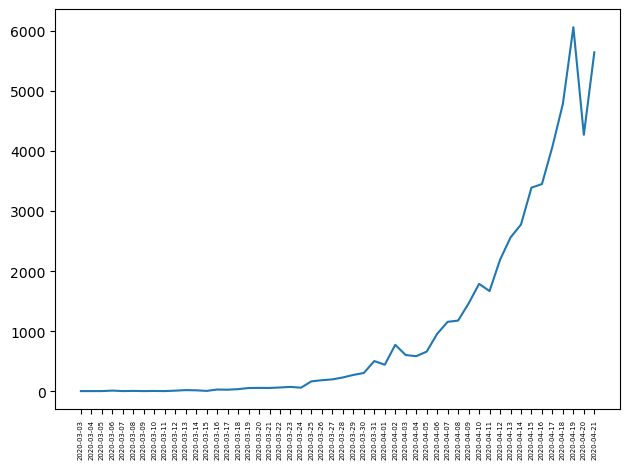

In [7]:
plt.plot( data_rus['date'][:50].tolist(),data_rus['new_cases'][:50].tolist())
plt.tick_params(axis='x',labelsize=5, rotation=90)
plt.tight_layout()
plt.show()

Для общего количества случаев

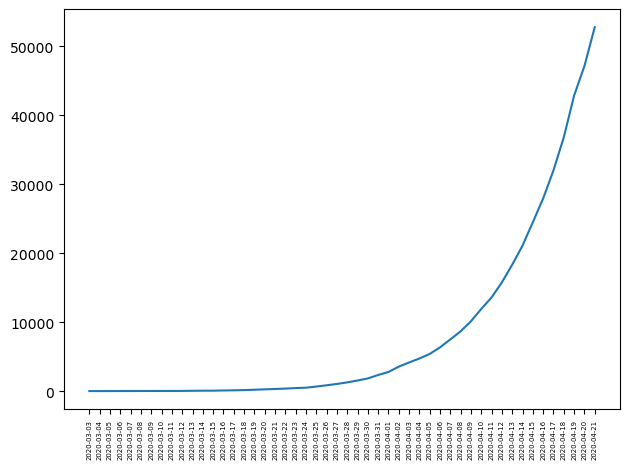

In [8]:
plt.plot( data_rus['date'][:50].tolist(),data_rus['total_cases'][:50].tolist())
plt.tick_params(axis='x',labelsize=5, rotation=90)
plt.tight_layout()
plt.show()

Использование линейной регресии для экспоненциального предположения

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
def get_train_all_data(data, train_val=50, target='new_cases'):
    X_train = np.arange(train_val).reshape(-1,1)
    Y_train = data[target][:train_val].values.reshape(-1,1)
    
    X = np.arange(len(data)).reshape(-1,1)
    Y = data[target].values.reshape(-1,1)
    
    return X_train, Y_train, X, Y

In [11]:
X_train, Y_train, X, Y = get_train_all_data(data_rus)

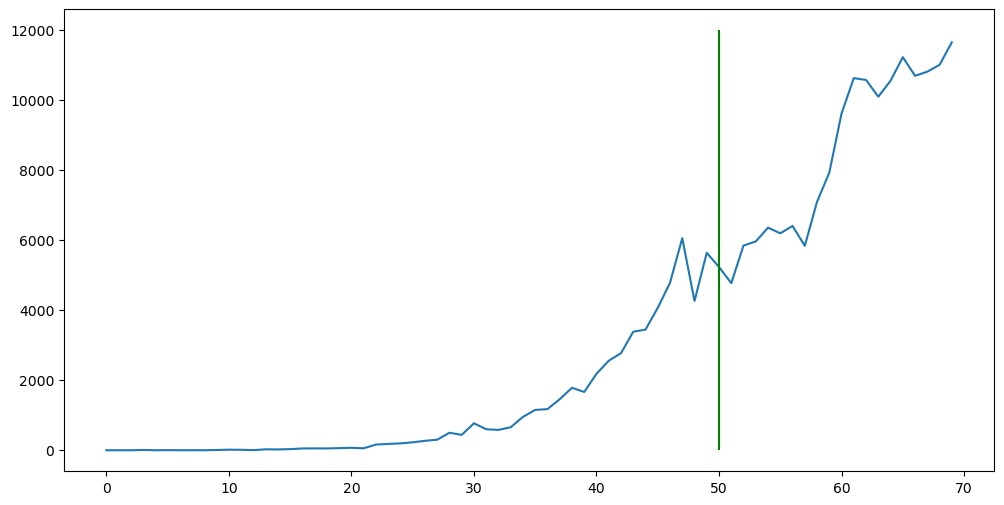

In [12]:
model = LinearRegression().fit(X_train, np.log(Y_train))
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Y[:70]);
plt.vlines(50, 0, 12000, color='green');

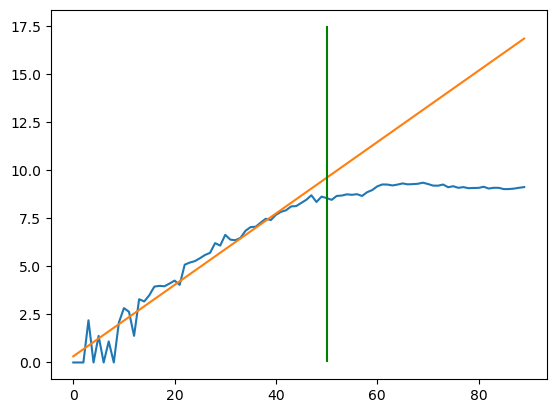

In [13]:
plt.plot( np.log(Y)[:90]) 
plt.plot( model.predict(X)[:90] )
plt.vlines(50, 0, 17.5, color='green');

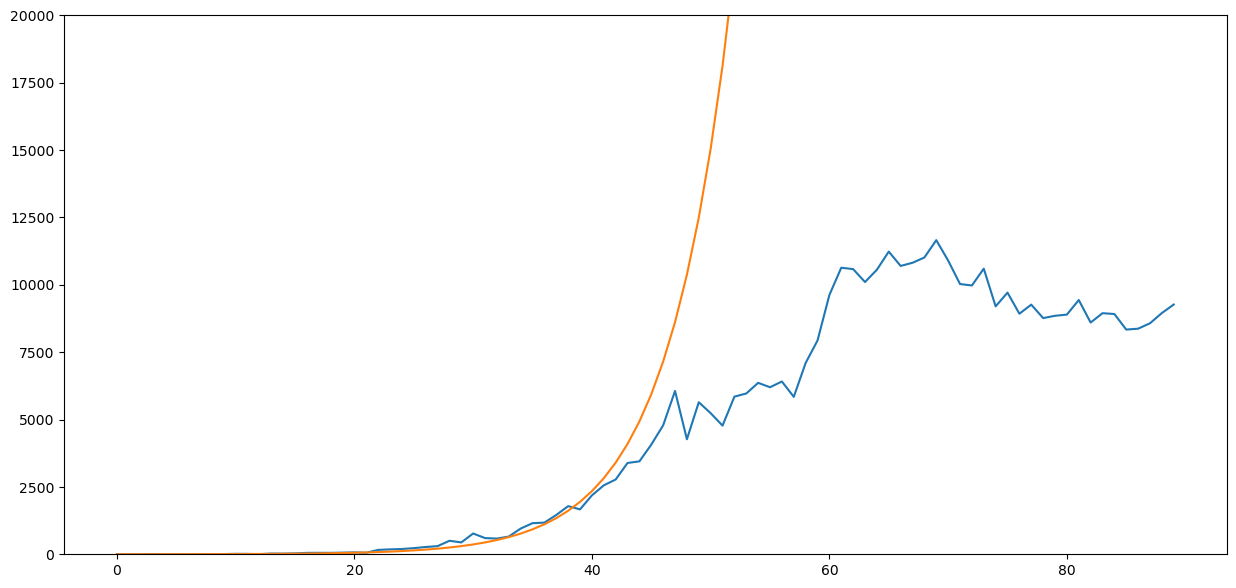

In [14]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

ax.plot( Y[:90] )
ax.plot( np.exp(model.predict(X)[:90] ))
ax.vlines(50, 0, 17.5, color='green');
ax.set_ylim((0, 10**5/5));

Нахождение апостериорного распредления для данной задачи

In [15]:
def bayesian_update(mu, sigma, x, y, sigma_noise=0.25):

    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + np.matmul(x.T, x) /(sigma_noise ** 2))
    mu_n = np.matmul(sigma_n, (np.matmul(np.linalg.inv(sigma), mu.T) + np.matmul(x.T, y) /(sigma_noise ** 2)))
    
    return mu_n, sigma_n

In [16]:
def get_bayesian_param(X, Y):
    mu_0 = np.zeros(2)
    sigma_0 = 2 * np.identity(2)
    
    mu, sigma = mu_0, sigma_0
    
    for x, y in zip(X, Y):
        x = np.array([1, x]).reshape((1,-1))
        mu, sigma = bayesian_update(mu, sigma, x, y)
    return mu, sigma

mu, sigma = get_bayesian_param(np.arange(X_train.shape[0]), np.log(Y_train))
mu, sigma

(array([0.31992491, 0.18598606]),
 array([[ 4.84118340e-03, -1.46702414e-04],
        [-1.46702414e-04,  5.99159604e-06]]))

Сэмплирование нескольких экспонент

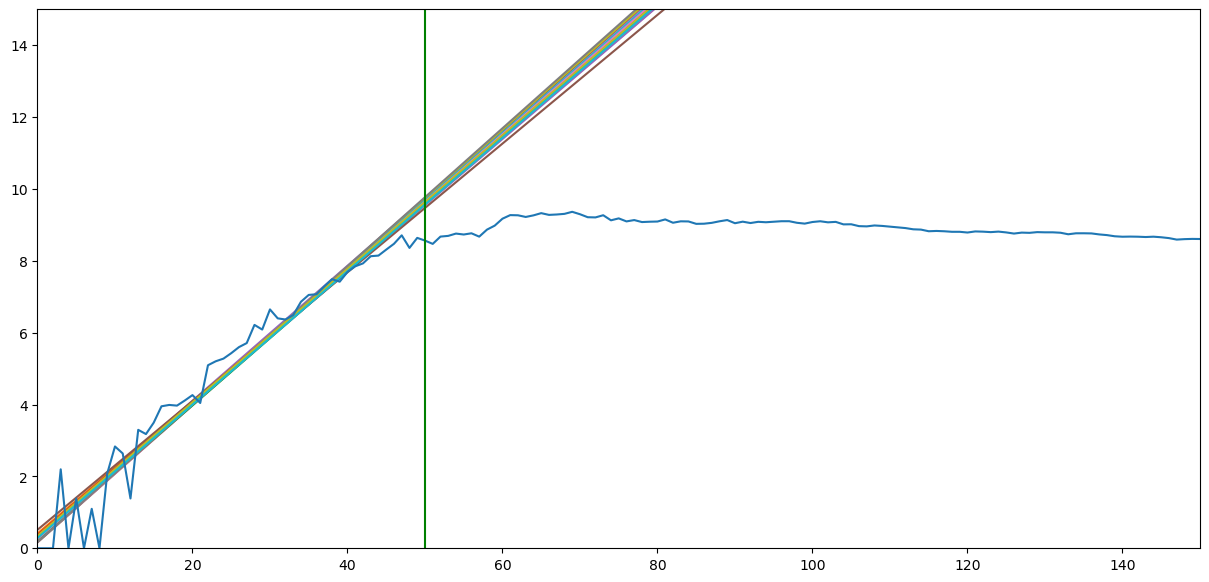

In [17]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()
w_sample = np.random.multivariate_normal(mu, sigma, 20)

for w in w_sample:
    x = np.array([[1, i] for i in X.reshape(-1)])
    ax.plot(X.reshape(-1), np.matmul(x, w))
    
ax.plot(X.reshape(-1), np.log(Y.reshape(-1)))
ax.vlines(50, 0, 70, color='green')
ax.set_ylim((0, 15))
ax.set_xlim((0, 150));

In [18]:
date = [
    '2020-05-01',
    '2020-06-01',
    '2020-09-01'
]

count_day = []
for cur_date in date:
    diff_day = (datetime.strptime(cur_date, "%Y-%m-%d") - datetime.strptime(START_DAY, "%Y-%m-%d")).days
    count_day.append(int(diff_day))

In [19]:
for days in count_day:
    w_sample = np.random.multivariate_normal(mu, sigma, 1)
    x = np.array([[1, i] for i in X[:days + 1].reshape(-1)])
    count_sick = np.round(np.sum([np.exp(np.matmul(i, w)) for i in x]))
    print(f"на {days} день = {count_sick} ")

на 59 день = 448472.0 
на 90 день = 141727538.0 
на 182 день = 3714967917595758.0 


Для новых случаев за день

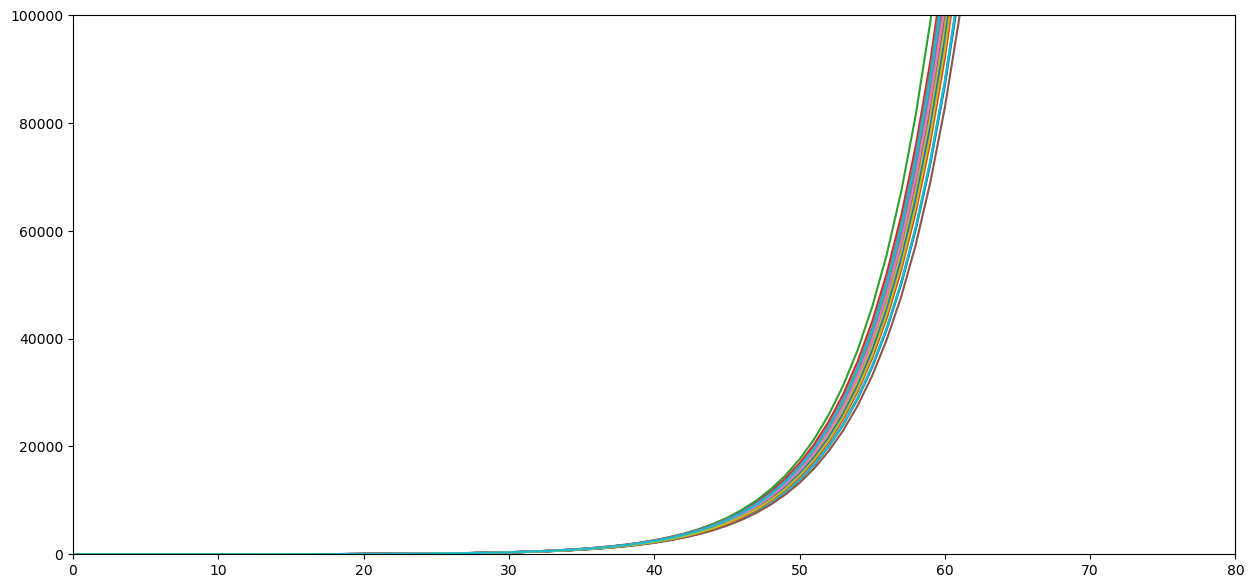

In [20]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

w_sample = np.random.multivariate_normal(mu, sigma, 30)
for w in w_sample:
    x = np.array([[1, i] for i in X.reshape(-1)])
    new_cases = [np.exp(np.matmul(w, i)) for i in x]
    ax.plot(X.reshape(-1), new_cases)
    
ax.set_ylim((0, 10**5))
ax.set_xlim((0, 80));

## Задание 2

Если взять плотность предложенного распределения, можно заметить, что у нас фигурирует многочлен второй степени (exp(от многочлена второй степени x^2)) поэтому можно попробовать сделать предположение, что ln(y) = w_0 + w_1 * x + w_2 * x^2

In [21]:
def get_bayesian_param_square(X, Y, noise=0.25):
    mu_0 = np.zeros(3)
    sigma_0 = 2 * np.identity(3)
    
    mu, sigma = mu_0, sigma_0
    
    for x, y in zip(X, Y):
        x = np.array([1, x, x**2]).reshape((1,-1))
        mu, sigma = bayesian_update(mu, sigma, x, y, noise)
    return mu, sigma

mu_sq, sigma_sq = get_bayesian_param_square(np.arange(X_train.shape[0]), np.log(Y_train))
mu_sq, sigma_sq

(array([-0.39442451,  0.27544443, -0.00182676]),
 array([[ 1.03418202e-02, -8.35550210e-04,  1.40664147e-05],
        [-8.35550210e-04,  9.22563876e-05, -1.76154492e-06],
        [ 1.40664147e-05, -1.76154492e-06,  3.59711123e-08]]))

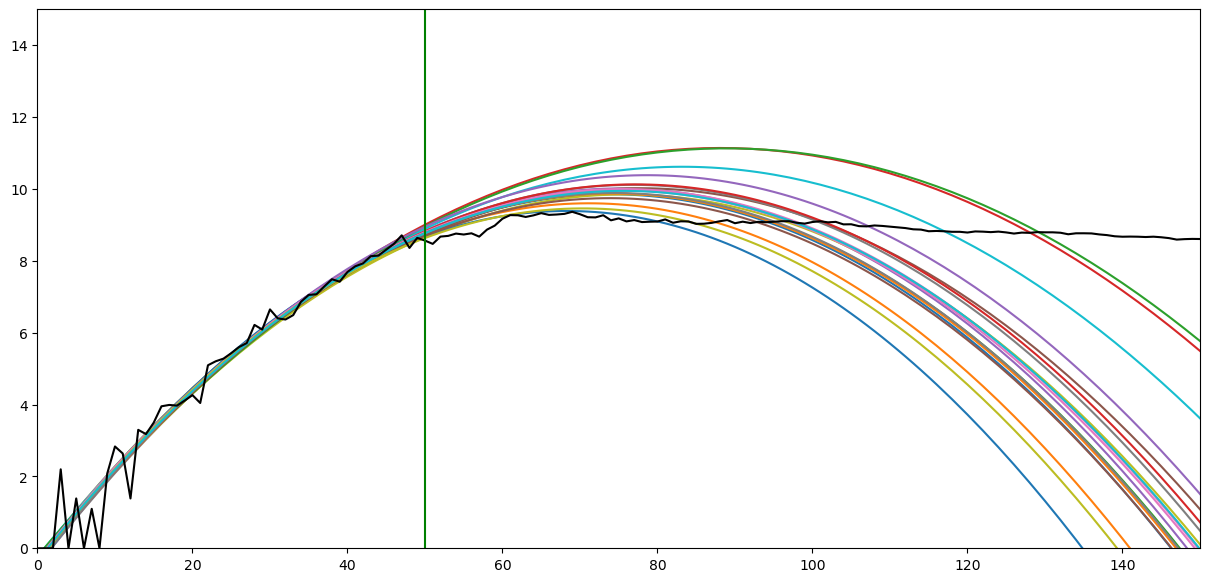

In [22]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()
w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, 20)

for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)])
    ax.plot(X.reshape(-1), np.matmul(x, w))
    
ax.plot(X.reshape(-1), np.log(Y.reshape(-1)), color='black')
ax.vlines(50, 0, 70, color='green')
ax.set_ylim((0, 15))
ax.set_xlim((0, 150));

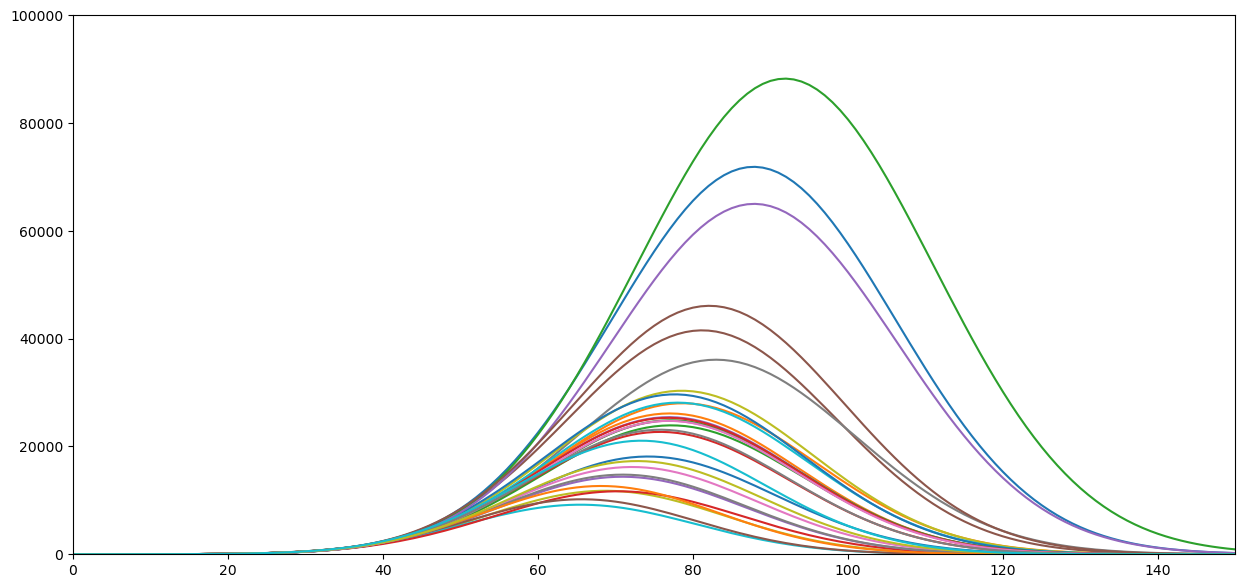

In [23]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, 30)
for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)])
    new_cases = [np.exp(np.matmul(w, i)) for i in x]
    ax.plot(X.reshape(-1), new_cases)
    
ax.set_ylim((0, 10**5))
ax.set_xlim((0, 150));

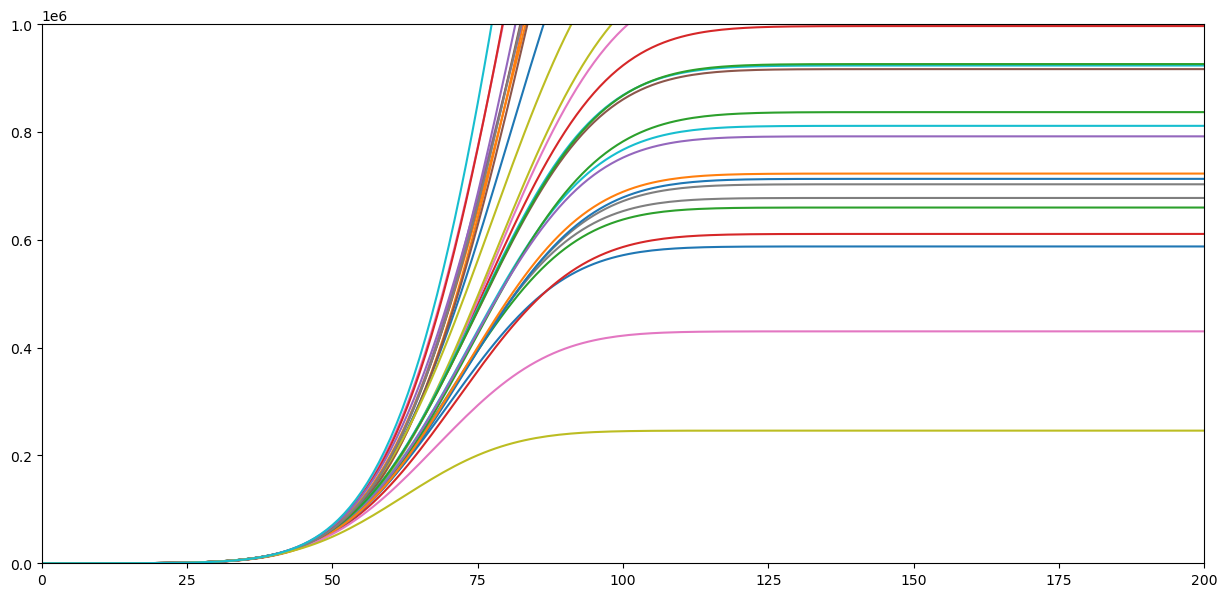

In [24]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, 30)
for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)])
    total_cases = np.cumsum([np.exp(np.matmul(w, i)) for i in x])
    ax.plot(X.reshape(-1), total_cases)
    
ax.set_ylim((0, 10**6))
ax.set_xlim((0, 200));

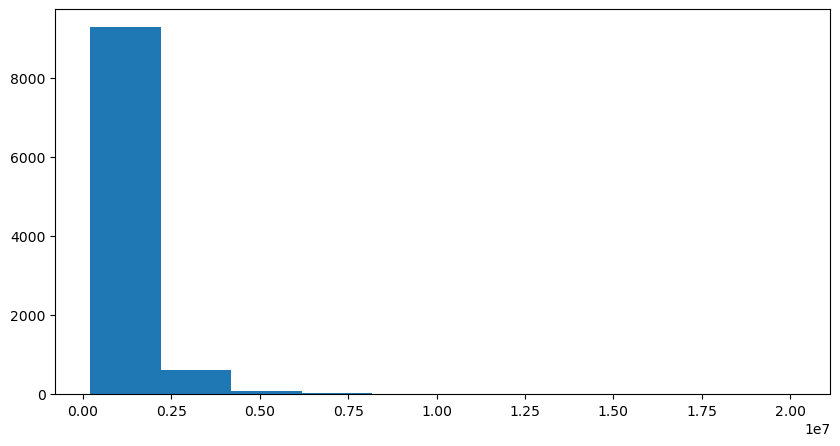

In [25]:
num_gr = 10**4
w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, num_gr)
all_total_cases = []
for w in w_sample:
    x = np.array([[1, i, i**2] for i in X.reshape(-1)])
    total_cases = np.cumsum([np.exp(np.matmul(w, i)) for i in x])
    all_total_cases.append(total_cases[-1])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.hist(all_total_cases);

In [26]:
cases_perc = [10, 90, 99.995]
for case in cases_perc:
    print(f'for case with perc = {case}, count = {np.percentile(all_total_cases, case)}')

for case with perc = 10, count = 504078.8123447443
for case with perc = 90, count = 1953758.392350171
for case with perc = 99.995, count = 19498524.709529486


In [27]:
data_rus['total_cases']

0              3.0
1              3.0
2              4.0
3             13.0
4             13.0
           ...    
1095    22002485.0
1096    22016406.0
1097    22029824.0
1098    22040875.0
1099    22051220.0
Name: total_cases, Length: 1100, dtype: float64

## Попробуем посмотреть данные для других стран

In [28]:
oth_country = [
    'Italy',
    'United Kingdom',
    'United States',
    'China',
    'Central African Republic',
    'Australia',
    'Brazil',
    'Russia'
]

In [29]:
def draw_plot(data, limit=100, title='', step=30):
    plt.plot( data['date'][:limit].tolist(),data['new_cases'][:limit].tolist())
    plt.tick_params(axis='x',labelsize=5, rotation=45)
    plt.tight_layout()
    plt.xticks(np.arange(0,limit, step))
    plt.title(title)
    plt.show()

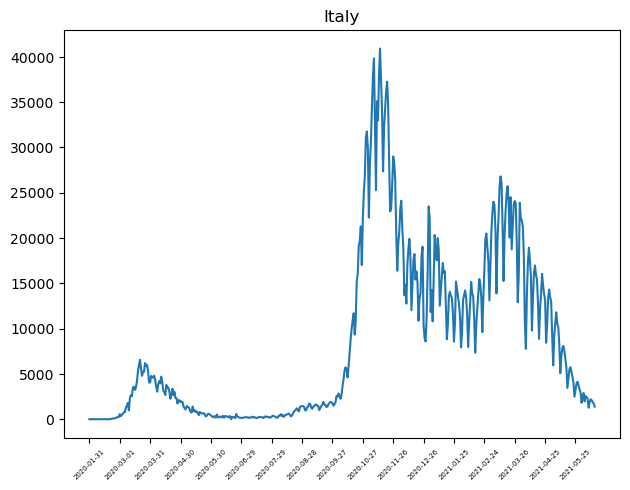

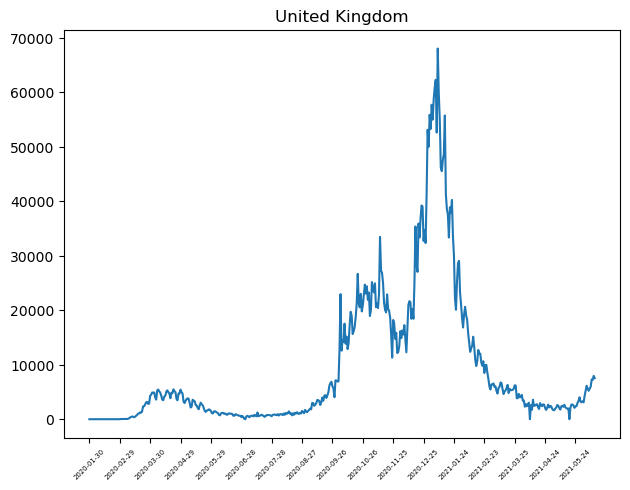

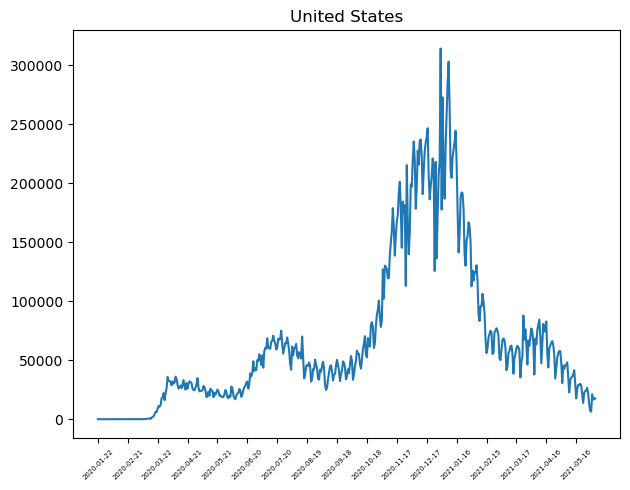

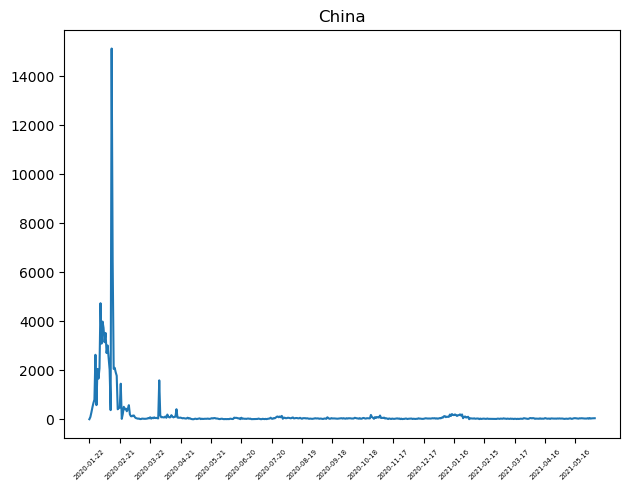

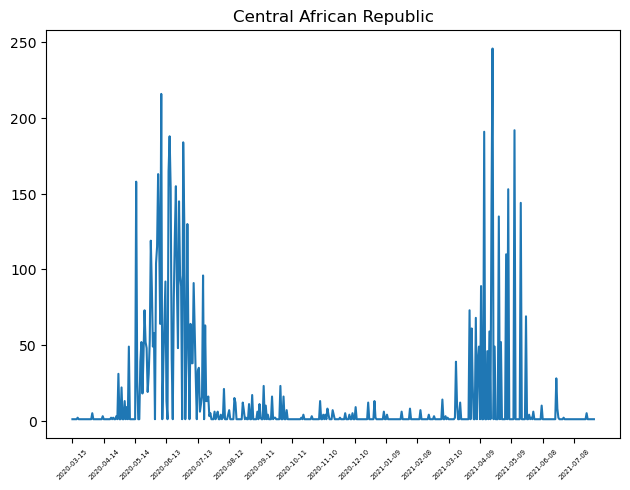

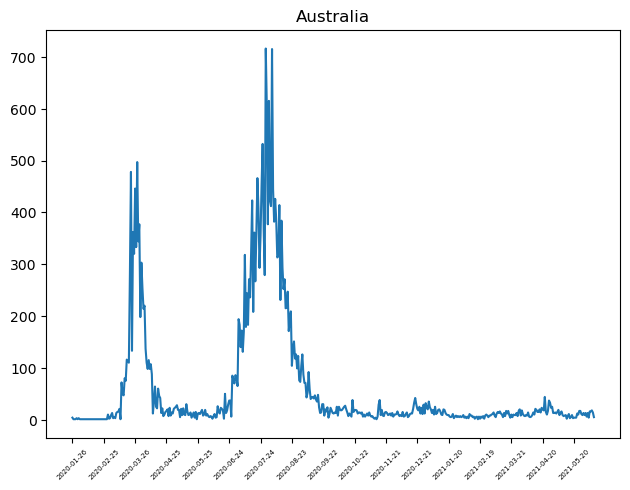

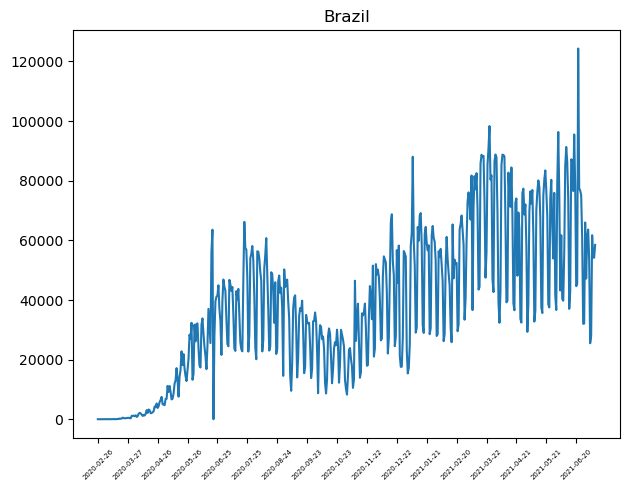

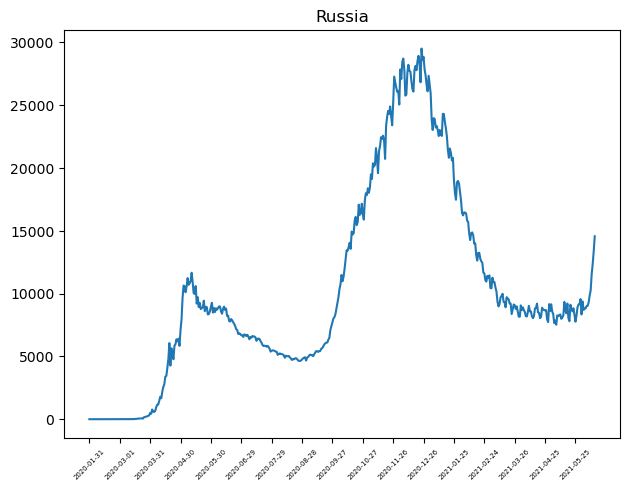

In [780]:
for con in oth_country:
    draw_plot(data[data['location']==con], 500, con)

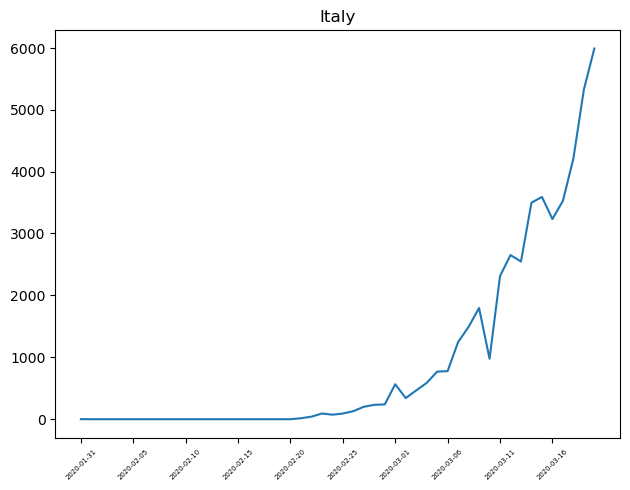

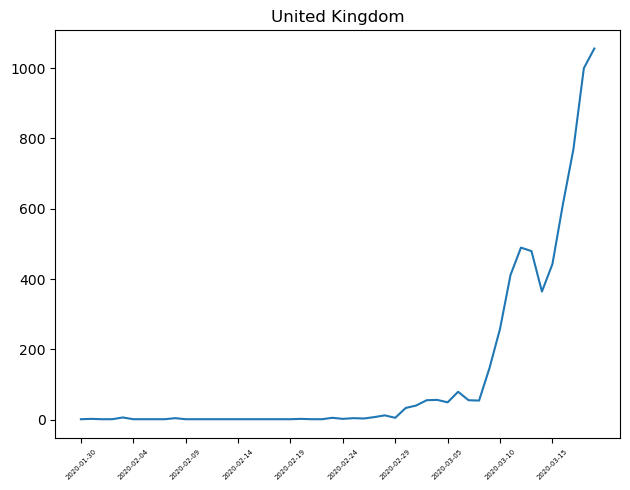

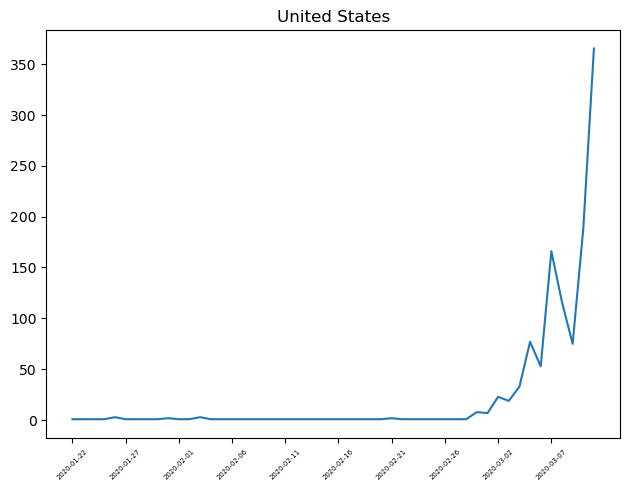

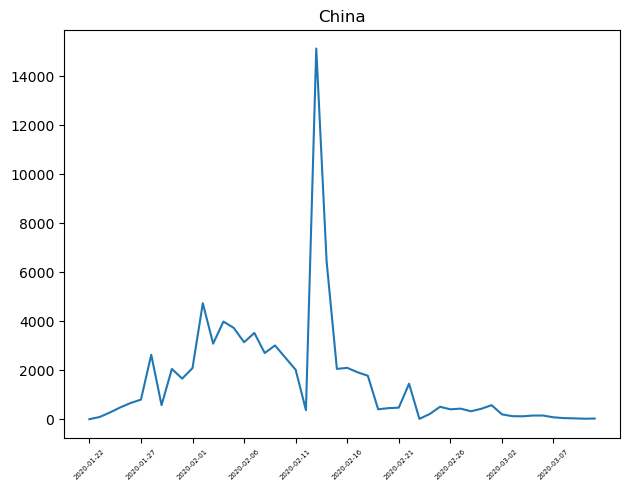

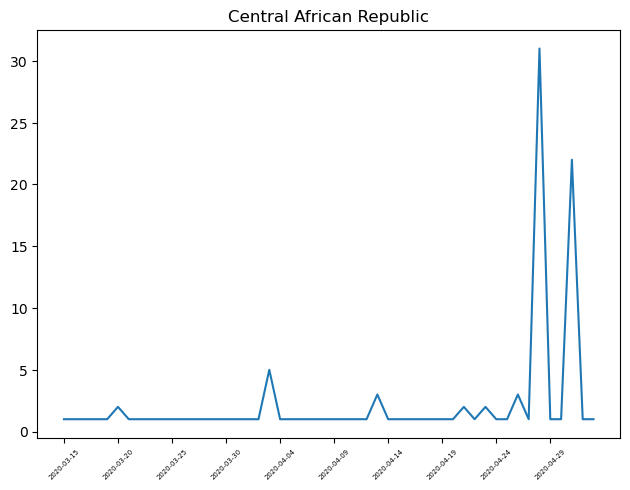

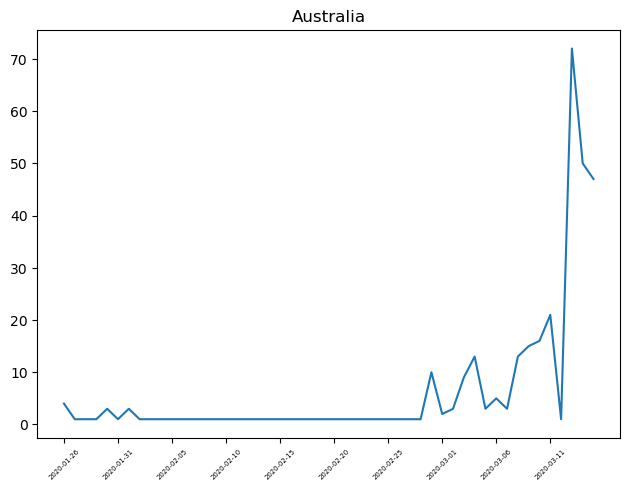

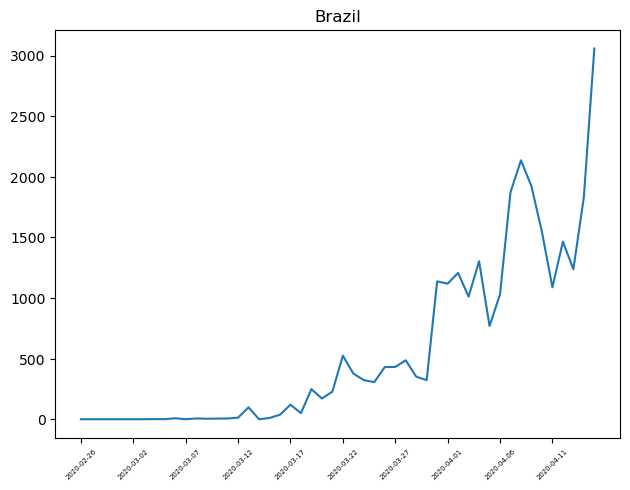

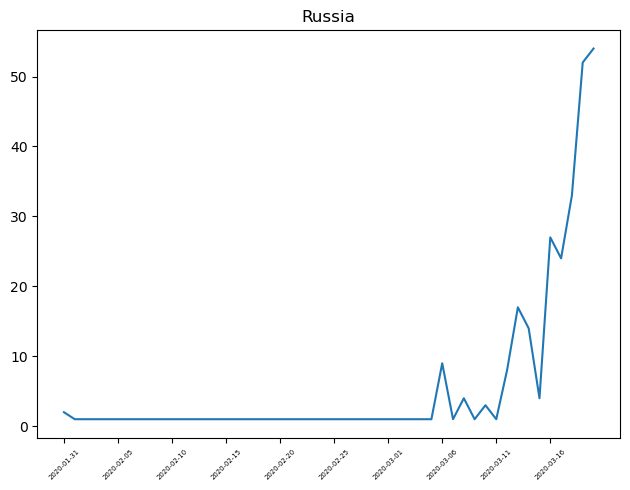

In [781]:
for con in oth_country:
    draw_plot(data[data['location']==con], 50, con, step=5)

Следовательно можно принять решение, что начало отсчета будет следующим: 
- Italy     = '2020-02-23'
- UK        = '2020-03-31'
- USA       = '2020-02-29'
- China     = '2020-01-22'
- Australia = '2020-02-28'

In [39]:
start_days = {
    'Italy'         : '2020-02-23',
    'United Kingdom': '2020-03-31',
    'United States' : '2020-02-29',
    'China'         : '2020-01-22',
    'Australia'     : '2020-02-28',
}
oth_country = start_days.keys()

In [40]:
data.loc[(data['new_cases']==0) | (data['new_cases'].isna()), 'new_cases'] = 1

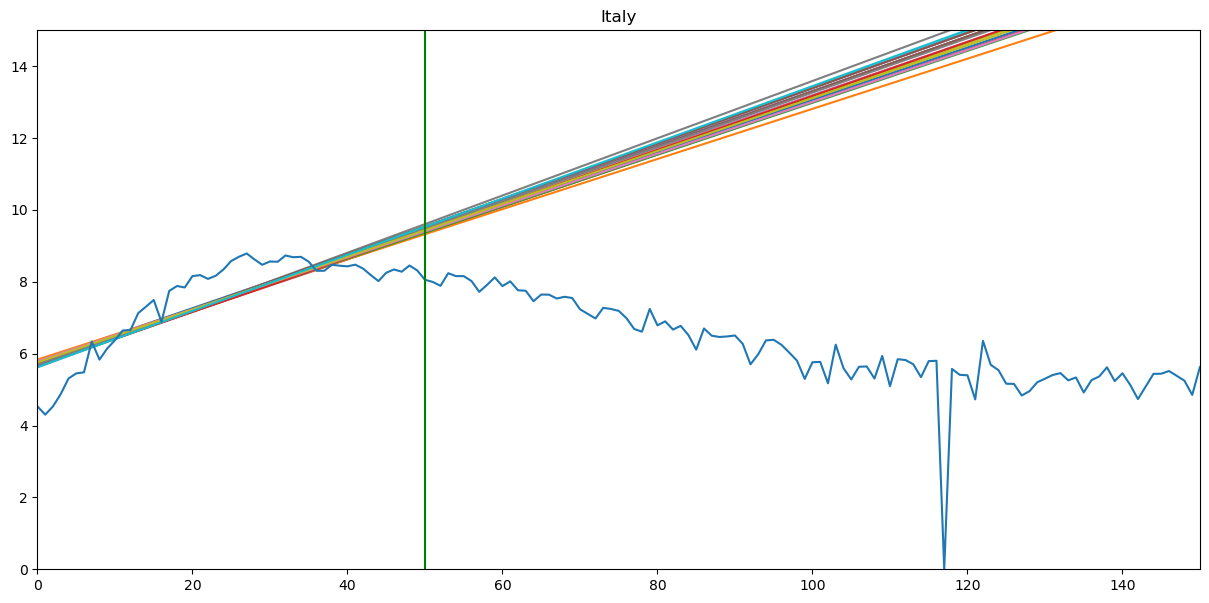

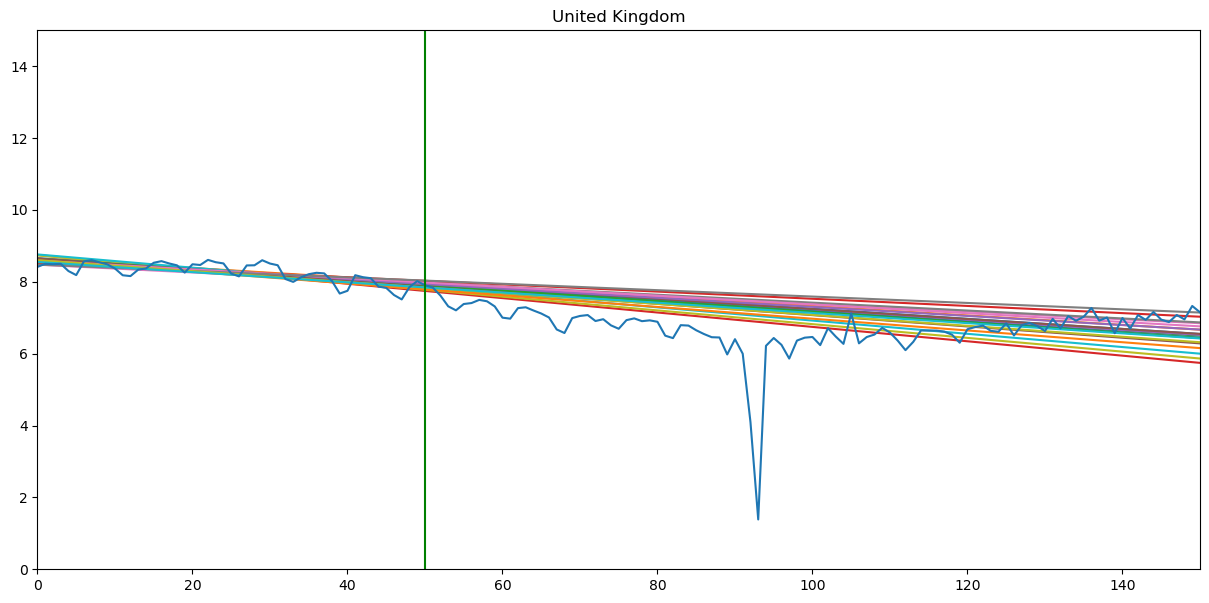

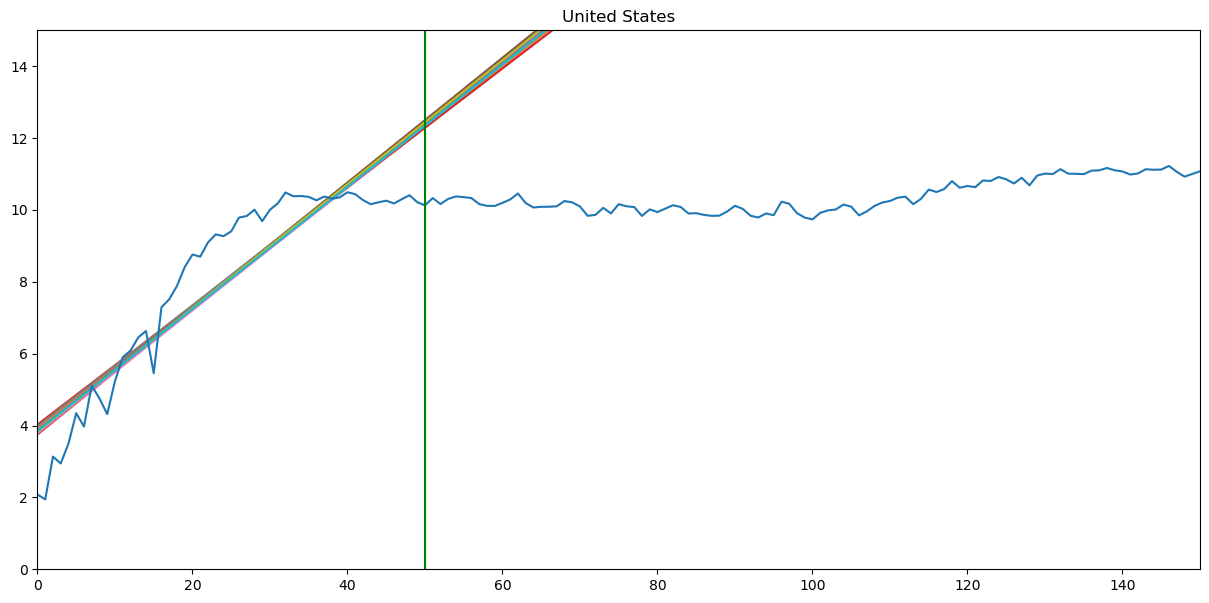

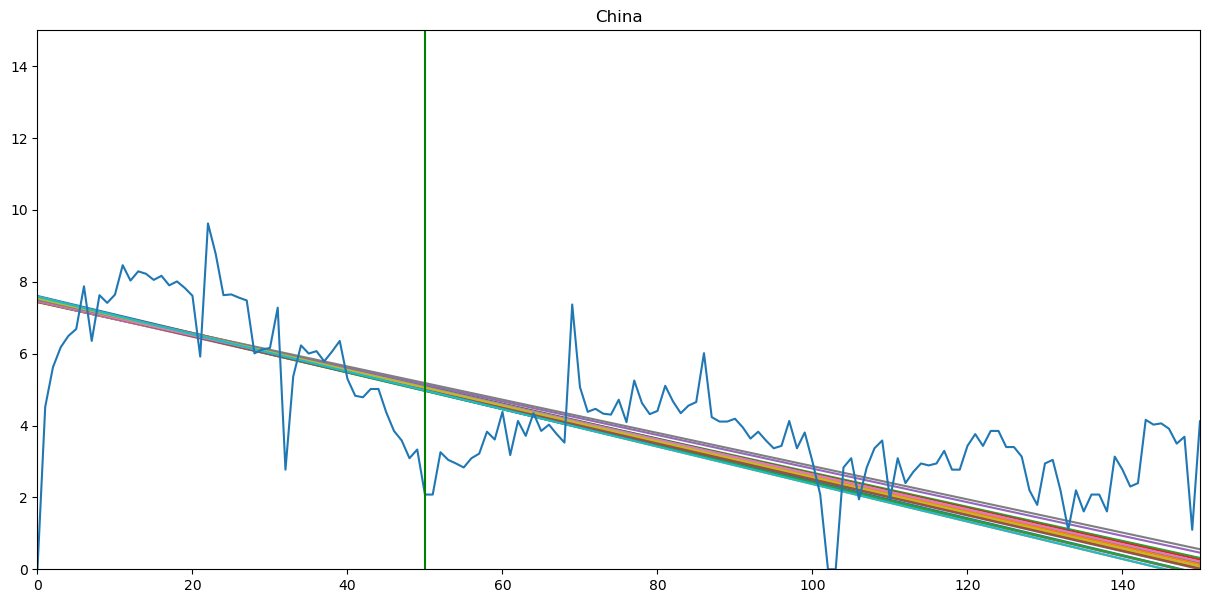

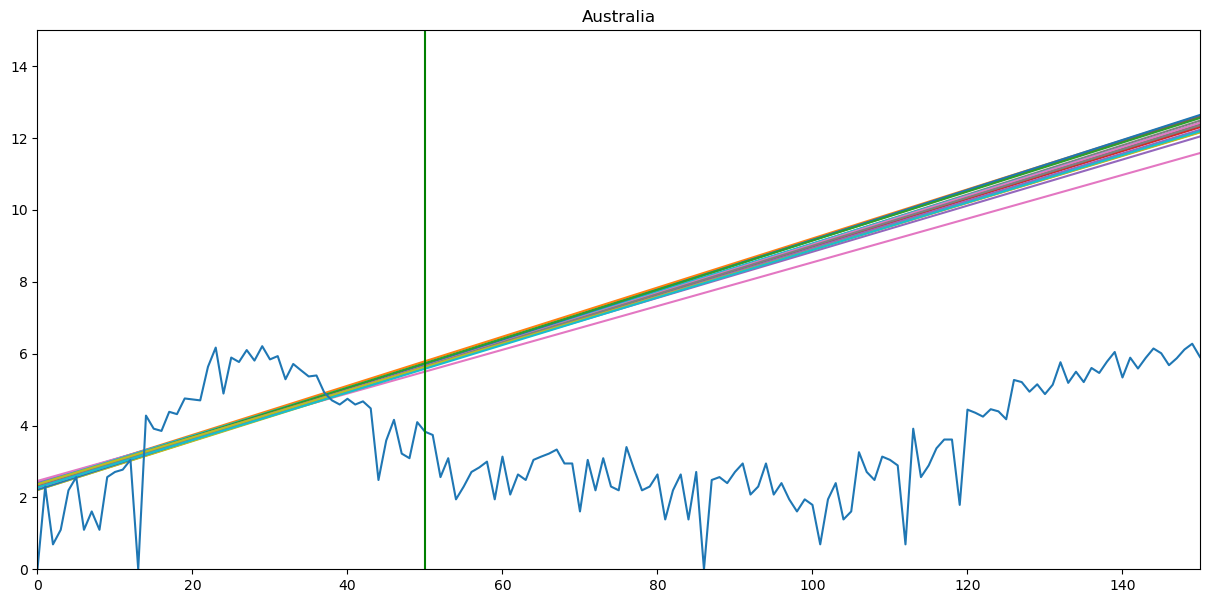

In [42]:
for con in oth_country:
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot()
    
    train_size = 50
    
    Y_loc = data.loc[(data['date']>=start_days[con]) & (data['location']==con)]['new_cases'].values.reshape(-1,1)
    X_loc = np.arange(len(Y_loc))
    
    mu, sigma = get_bayesian_param(np.arange(train_size), np.log(Y_loc))
    w_sample = np.random.multivariate_normal(mu, sigma, 20)

    for w in w_sample:
        x = np.array([[1, i] for i in X_loc])
        ax.plot(X_loc, np.matmul(x, w))

    ax.plot(X_loc, np.log(Y_loc.reshape(-1)))
    ax.set_title(con)
    ax.vlines(train_size, 0, 70, color='green')
    ax.set_ylim((0, 15))
    ax.set_xlim((0, 150));

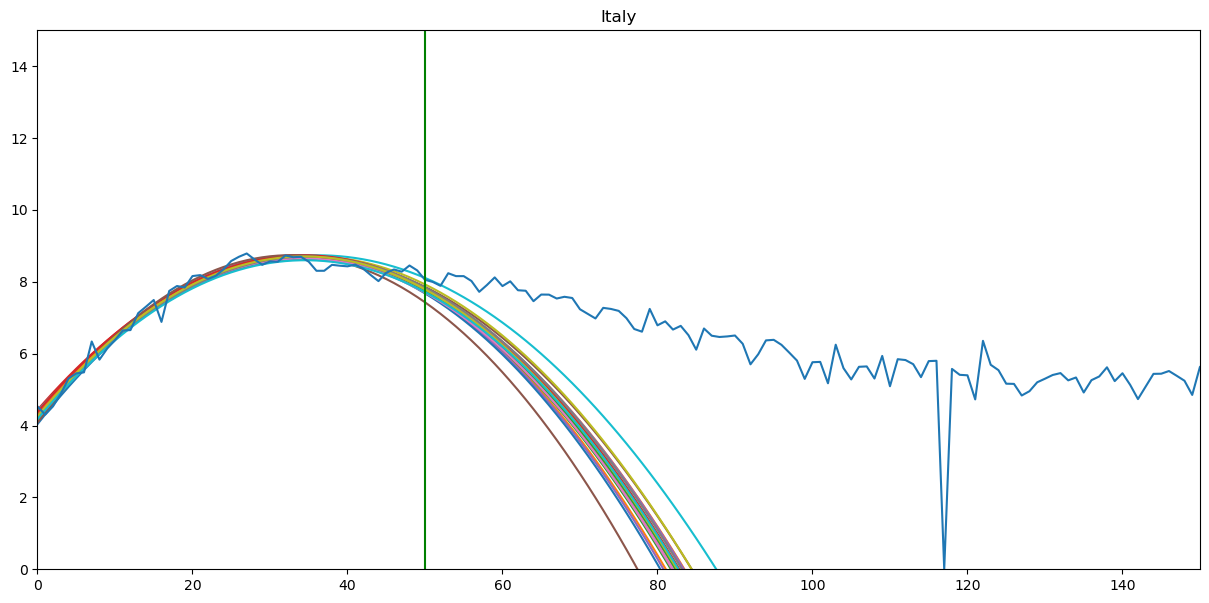

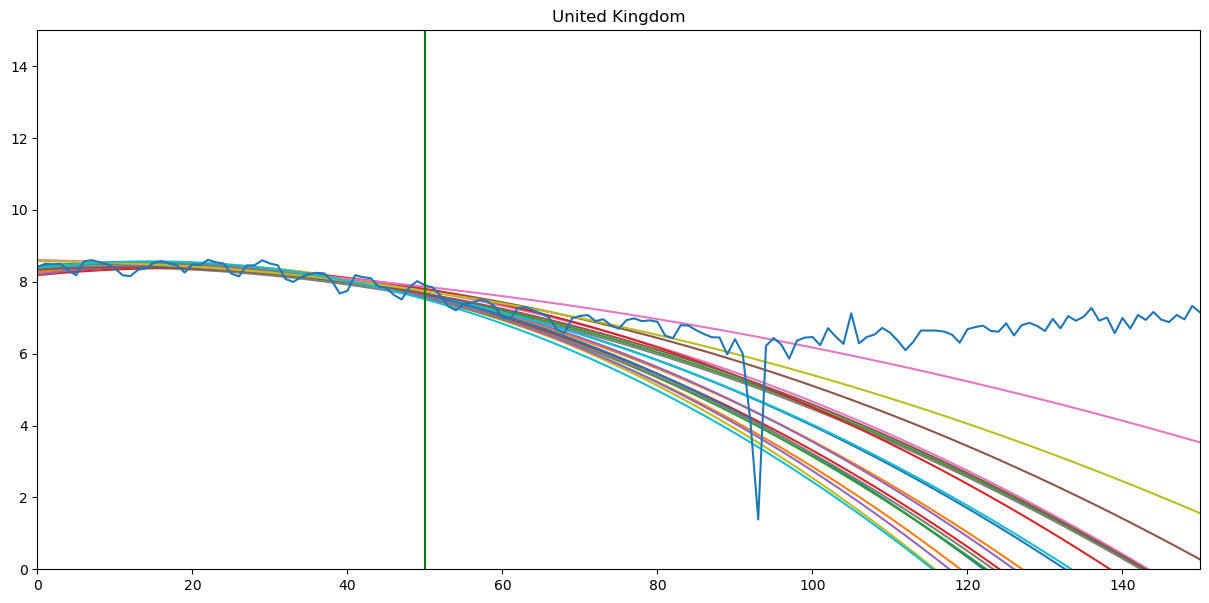

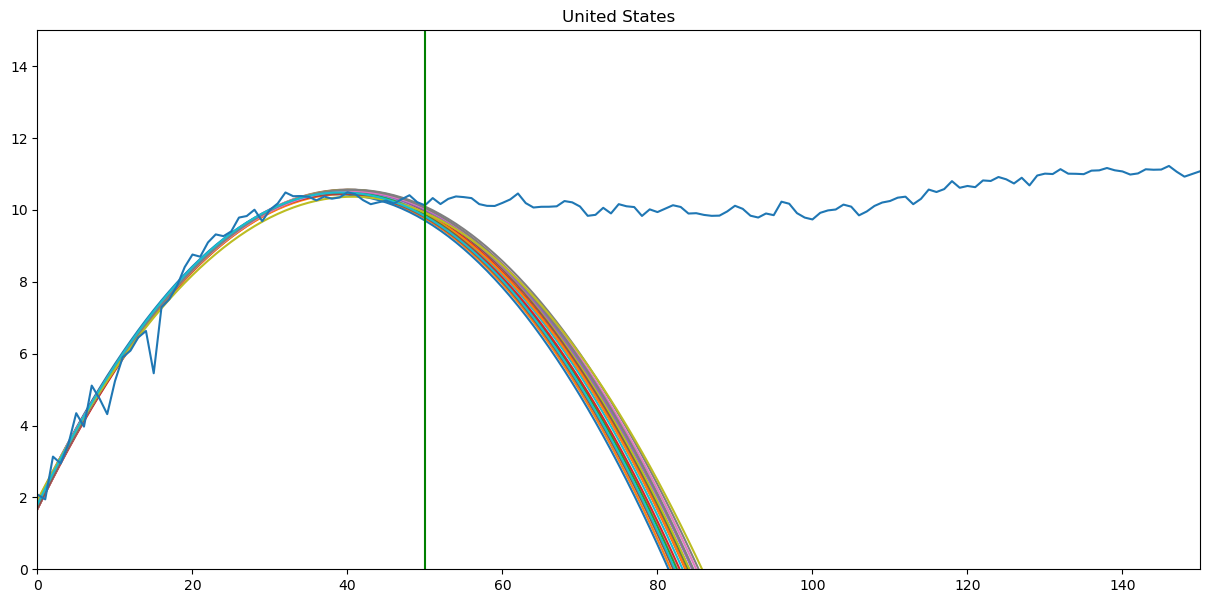

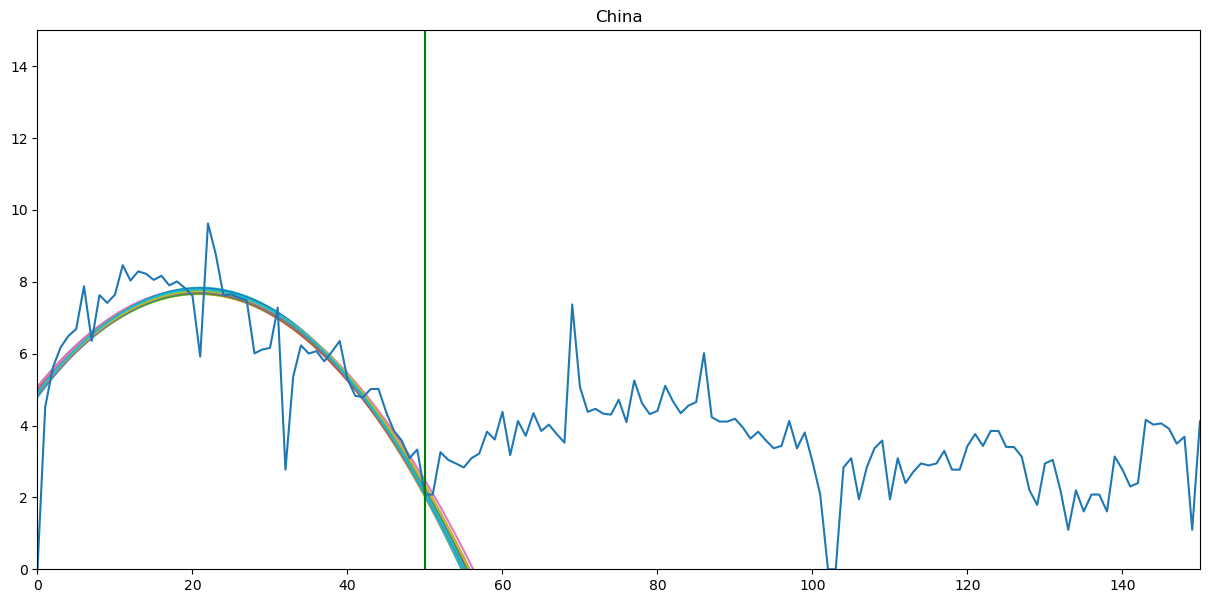

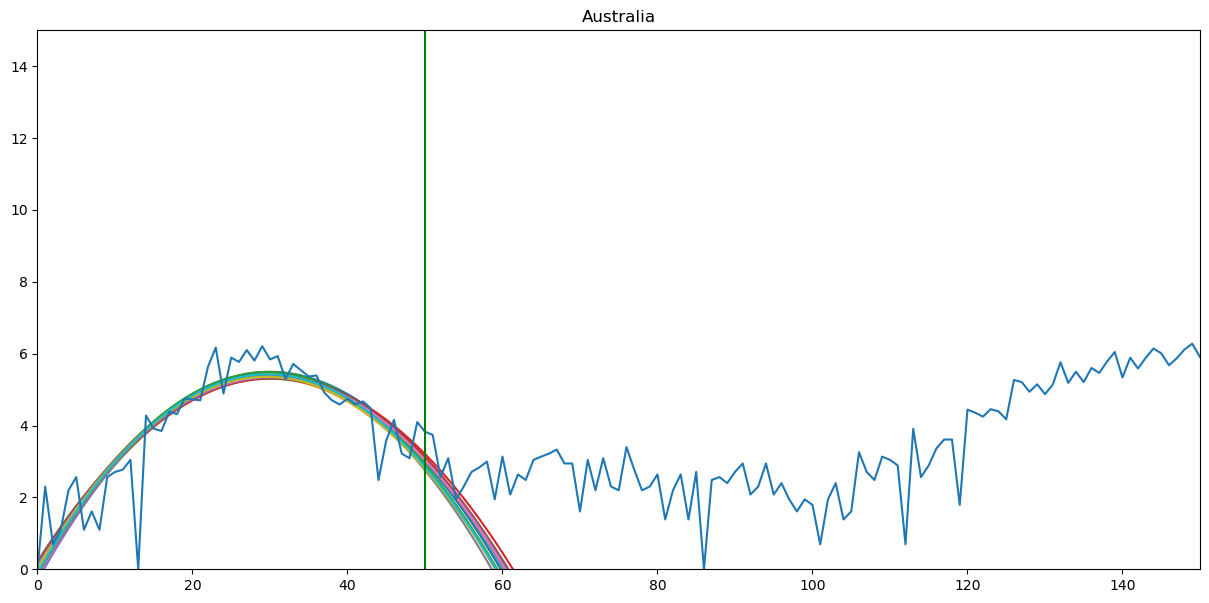

In [43]:
for con in oth_country:
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot()

    train_size = 50
    
    Y_loc = data.loc[(data['date']>=start_days[con]) & (data['location']==con)]['new_cases'].values.reshape(-1,1)
    X_loc = np.arange(len(Y_loc))
    
    mu_sq, sigma_sq = get_bayesian_param_square(np.arange(train_size), np.log(Y_loc))
    w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, 20)

    for w in w_sample:
        x = np.array([[1, i, i**2] for i in X_loc])
        ax.plot(X_loc, np.matmul(x, w))

    ax.plot(X_loc, np.log(Y_loc.reshape(-1)))
    ax.set_title(con)
    ax.vlines(train_size, 0, 70, color='green')
    ax.set_ylim((0, 15))
    ax.set_xlim((0, 150));

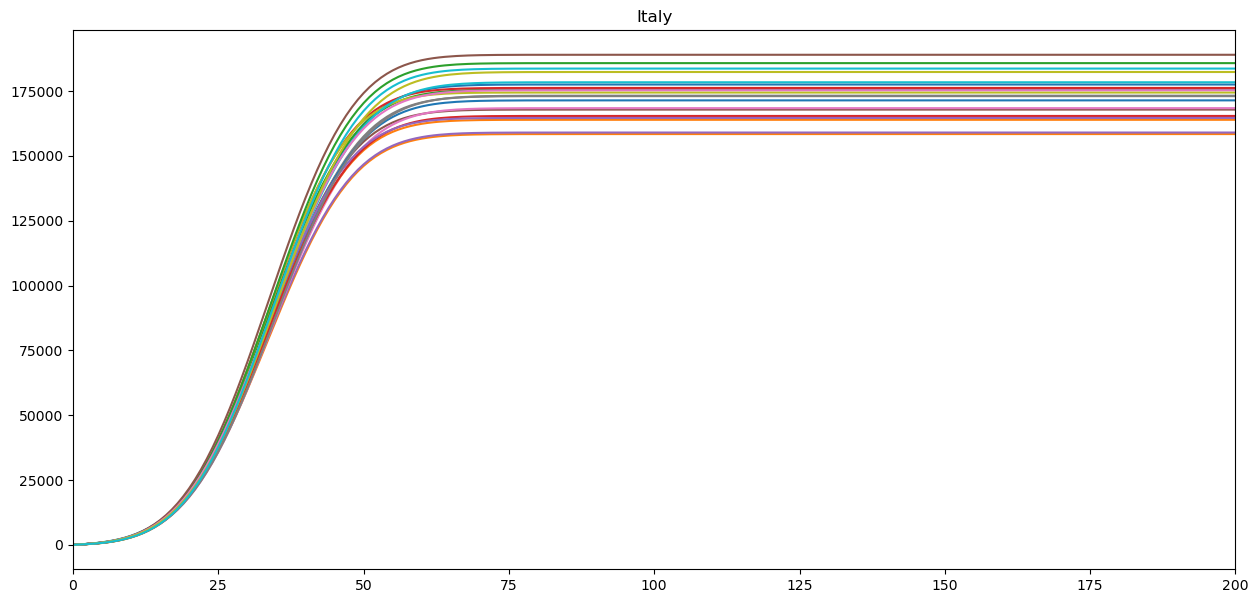

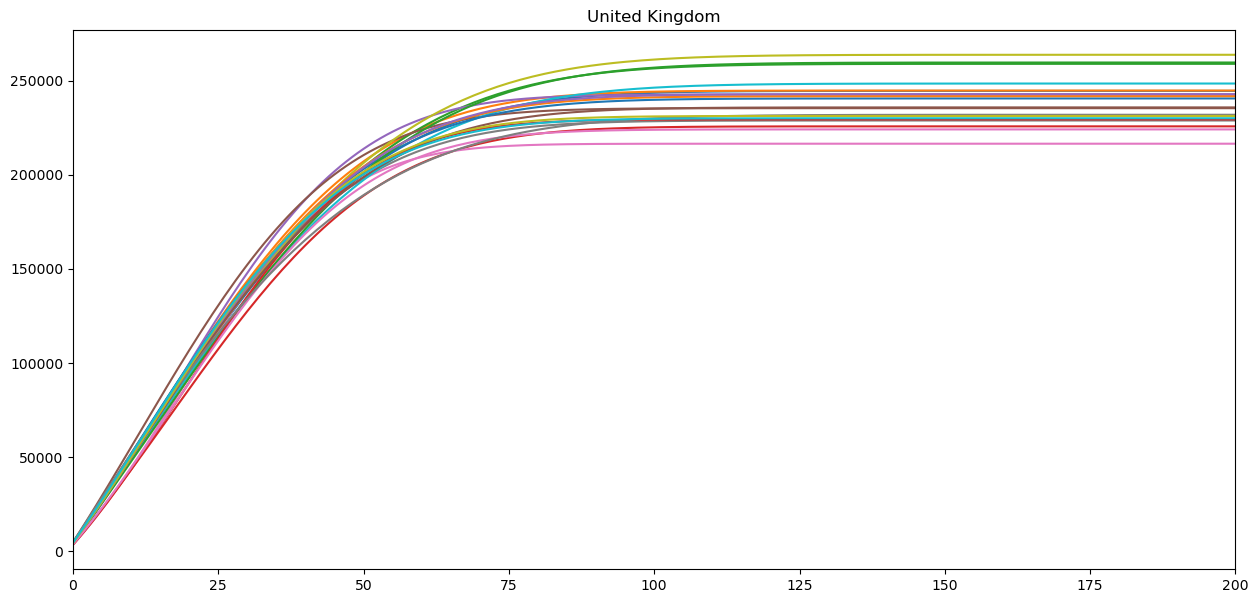

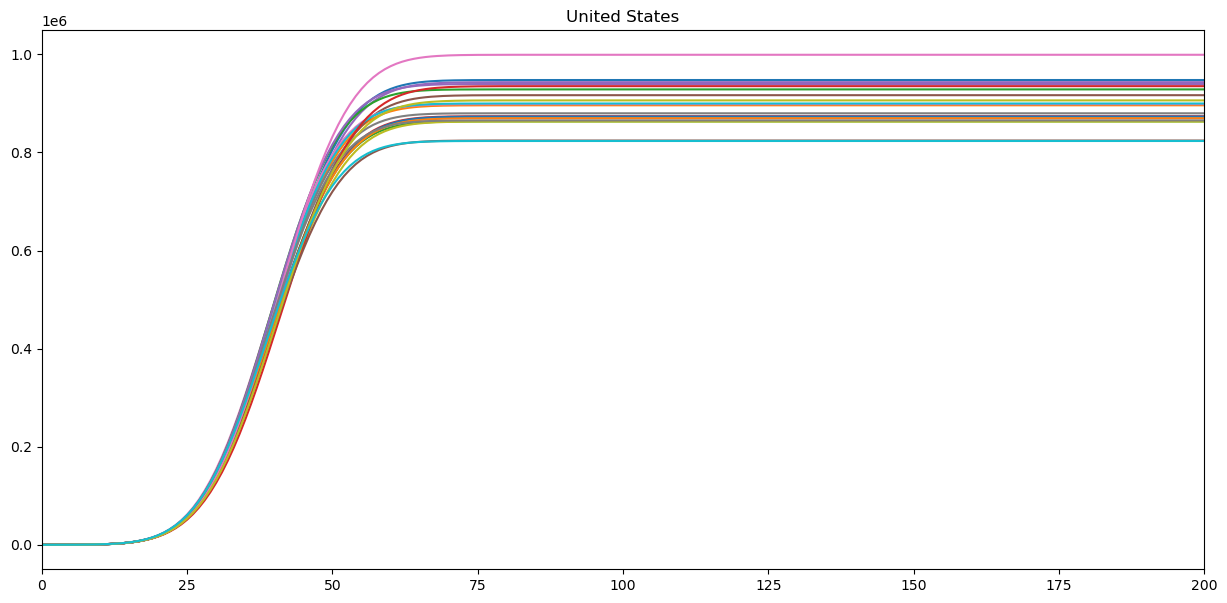

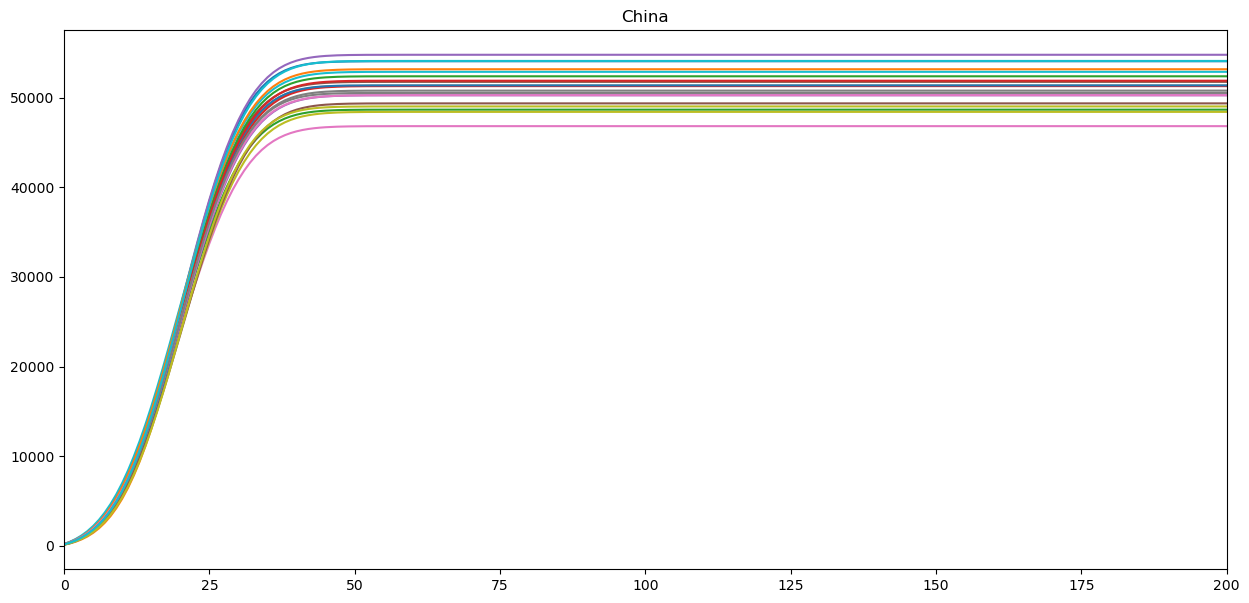

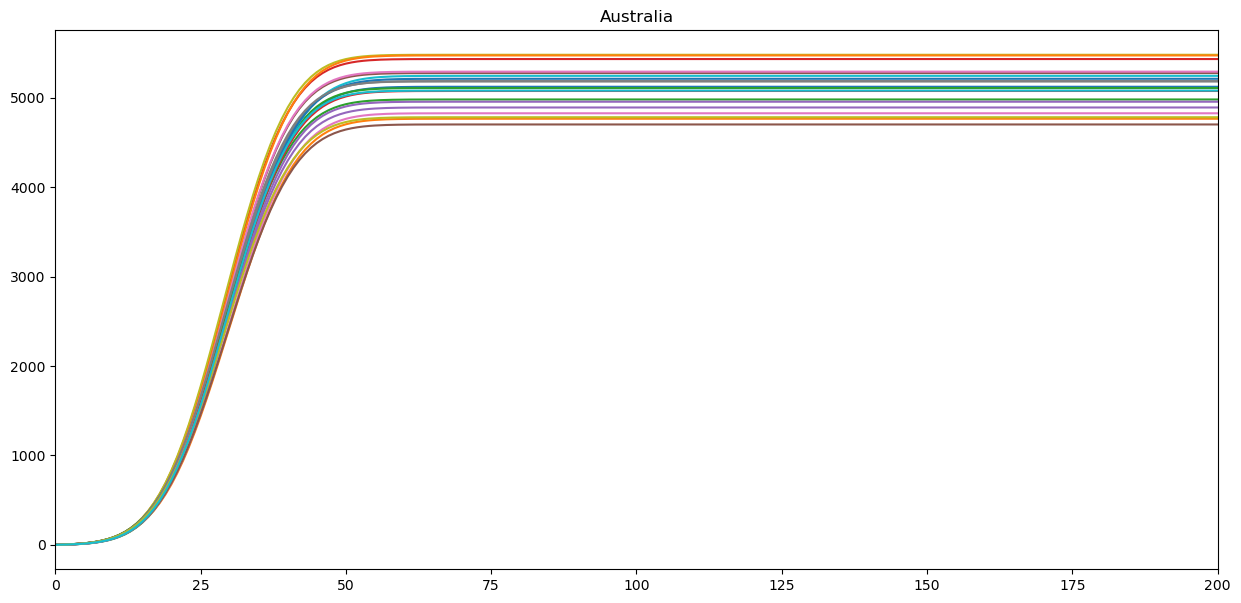

In [47]:
for con in oth_country:
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot()

    train_size = 50
    
    Y_loc = data.loc[(data['date']>=start_days[con]) & (data['location']==con)]['new_cases'].values.reshape(-1,1)
    X_loc = np.arange(len(Y_loc))
    
    mu_sq, sigma_sq = get_bayesian_param_square(np.arange(train_size), np.log(Y_loc))
    w_sample = np.random.multivariate_normal(mu_sq, sigma_sq, 20)

    for w in w_sample:
        x = np.array([[1, i, i**2] for i in X_loc])
        total_cases = np.cumsum([np.exp(np.matmul(w, i)) for i in x])
        ax.plot(X_loc, total_cases)

    ax.set_title(con)
    ax.set_xlim((0, 200));

По полученным данным можно визуальнно предположить, что есть возможнность разделить страны на кластеры (по скорости и характеру заболевания)
Условно у Италии, США и России схожий характер поведения графика (и если посмотреть на реальных данных, то видно, что у них действительно схожи этапы распространения)